# Scoring of Unexplained Wealth Risk

## Table of Contents
* [Introduction](#1)
* [Data Prep](#2)
* [EDA](#3)
* [Models](#4)
* [Results](#5)
* [Conclusions and Future Improvements](#6)

#### Library Imports

In [1]:
#!pip install delayed

In [38]:
import numpy as np
import pandas as pd
from matplotlib import pyplot

#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

#ML
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#Imbalanced Data
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

## Data Prep

Cleaning and generating datasets from json files.

In [3]:
# Load data
data = pd.read_json('data.json', lines=True)
data

,id_PEP,Rule,flag_data
0,9944,PEP01,"{'kids_actual': 0, 'kids_expected': 1, 'wife_a..."
1,6179,PEP01,"{'kids_actual': 2, 'kids_expected': 3, 'wife_a..."
2,702,PEP01,"{'kids_actual': 0, 'kids_expected': 1, 'wife_a..."
3,9970,PEP01,"{'kids_actual': 0, 'kids_expected': 1, 'wife_a..."
4,6126,PEP01,"{'kids_actual': 0, 'kids_expected': 1, 'wife_a..."
...,...,...,...
18894,32833,PEP27,{'am_live_property_rent_300more': 1}
18895,25822,PEP27,{'am_live_property_rent_300more': 1}
18896,4940,PEP27,{'am_live_property_rent_300more': 1}
18897,52064,PEP27,{'am_live_property_rent_300more': 1}


### 1. Dataframe of Scores

In [4]:
# List PEP ids
pep_id = data['id_PEP'].unique()

# Create DF
pep_ids = pd.DataFrame({'id_PEP':pep_id})
pep_ids

,id_PEP
0,9944
1,6179
2,702
3,9970
4,6126
...,...
9496,26254
9497,26078
9498,47966
9499,33880


In [5]:
# Work only with 'id_PEP' and 'Rule' columns
pivot = data[['id_PEP', 'Rule']]

# Generate pivot table
pivot = pd.pivot_table(pivot, index=['id_PEP'], columns=['Rule'], aggfunc=len, fill_value=0)
pivot

Rule,PEP01,PEP02,PEP03_avto,PEP03_home,PEP03_land,PEP04_adress,PEP04_region,PEP05,PEP09,PEP10,...,PEP18,PEP19,PEP20,PEP21,PEP22,PEP23,PEP24,PEP25,PEP26,PEP27
id_PEP,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,1,0,0,0,0,0,0,1,0,0,...,1,0,1,0,0,1,1,0,0,0
34,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
139,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54276,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54279,0,0,0,0,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
54282,0,1,1,1,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [6]:
# Create df of Scores
scores = pd.merge(pep_ids, pivot, on=['id_PEP'], how='outer')

#Add column PEP07
scores['PEP07'] = 0

#Replace NaN with 0
scores.fillna(0, inplace=True)

scores

,id_PEP,PEP01,PEP02,PEP03_avto,PEP03_home,PEP03_land,PEP04_adress,PEP04_region,PEP05,PEP09,...,PEP19,PEP20,PEP21,PEP22,PEP23,PEP24,PEP25,PEP26,PEP27,PEP07
0,9944,1,0,1,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,6179,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,702,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9970,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6126,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9496,26254,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9497,26078,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9498,47966,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9499,33880,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
# Dictionary of Rules
rules_dict = {'PEP01':0.1,
             'PEP02':0.4,
             'PEP03_avto':0.4,
             'PEP03_home':0.1,
             'PEP03_land':0.1,
             'PEP04_adress':0.7,
             'PEP04_region':0.1,
             'PEP05':0.4,
             'PEP07':0.8,
             'PEP09':0.5,
             'PEP10':0.2,
             'PEP11':0.2,
             'PEP13':0.7,
             'PEP15':0.8,
             'PEP16':1,
             'PEP17':0.8,
             'PEP18':0.4,
             'PEP19':0.6,
             'PEP20':0.8,
             'PEP21':1,
             'PEP22':0.8,
             'PEP23':0.5,
             'PEP24':1,
             'PEP25':0.7,
             'PEP26':0.9,
             'PEP27':0.3}

In [8]:
# Auxiliary function - compute individual scores
def calculate_score(rules, data):
    
    """ Calculates the individual score of a PEP.
        Expects a dictionary of rules and weights, and a dataframe.
        Returns the score."""
    
    score = 0
    for key, value in rules.items():
        score += data[key] * value
        
    return score.round(2)

In [9]:
# Auxiliary function - compute final scores
def calculate_final_score(data, column):
    
    """ Calculates the final score of a PEP.
        Expects a dataframe and the name of the column (str) with previously computed individual scores.
        Returns the final score."""

    highest_score = data[column].max()
    
    final_score = data[column] * 10 / highest_score
     
    return final_score.round(2)

In [10]:
# Create Scores column
scores['score'] = calculate_score(rules_dict, scores)

# Create Final Scores column
scores['final_score'] = calculate_final_score(scores, 'score')

In [11]:
# Create Risk class
conditions = [
    (scores['final_score'] <= 3),
    (scores['final_score'] > 3) & (scores['final_score'] <= 7),
    (scores['final_score'] > 7)]
choices = ['low', 'mid', 'high']
scores['risk'] = np.select(conditions, choices)

scores

,id_PEP,PEP01,PEP02,PEP03_avto,PEP03_home,PEP03_land,PEP04_adress,PEP04_region,PEP05,PEP09,...,PEP22,PEP23,PEP24,PEP25,PEP26,PEP27,PEP07,score,final_score,risk
0,9944,1,0,1,0,1,1,0,0,0,...,1,0,0,0,0,0,0,2.1,3.44,mid
1,6179,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.1,0.16,low
2,702,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.1,0.16,low
3,9970,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0.8,1.31,low
4,6126,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.1,0.16,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9496,26254,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0.7,1.15,low
9497,26078,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0.7,1.15,low
9498,47966,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.9,1.48,low
9499,33880,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.9,1.48,low


In [12]:
# Create CSV file
#scores.to_csv('scores.csv', index = False, header=True)

### 2. Dataframe of All Fields

In [13]:
# Normalize flag_data column to create more columns
all_fields = pd.concat([data['id_PEP'], pd.json_normalize(data.flag_data)], axis=1)
all_fields

,id_PEP,kids_actual,kids_expected,wife_actual,wife_expected,total_property_assets,total_property_assets_divide_income,sum_income,am_avto,am_avto_without_price,...,sum_prev_cash_assets,sum_cash_min_year,sum_cash_min_year_divide_sum_income_min_year,sum_income_min_year,sum_spending_divide_sum_income,am_company_noBeneficInform,am_company,sum_money_spending,sum_crypto,am_live_property_rent_300more
0,9944,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6179,2.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,702,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9970,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6126,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18894,32833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
18895,25822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
18896,4940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
18897,52064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [14]:
# Merge rows by id_PEP
all_fields = all_fields.groupby('id_PEP').max()

In [15]:
all_fields

,kids_actual,kids_expected,wife_actual,wife_expected,total_property_assets,total_property_assets_divide_income,sum_income,am_avto,am_avto_without_price,am_real_estate,...,sum_prev_cash_assets,sum_cash_min_year,sum_cash_min_year_divide_sum_income_min_year,sum_income_min_year,sum_spending_divide_sum_income,am_company_noBeneficInform,am_company,sum_money_spending,sum_crypto,am_live_property_rent_300more
id_PEP,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,5.470306e+07,10.2862,5318115.0,NaN,NaN,NaN,...,NaN,14171514.4,26.7159,530453.0,NaN,1.0,NaN,NaN,NaN,NaN
2,0.0,4.0,1.0,1.0,NaN,NaN,772961396.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,108.4764,91.0,NaN,NaN,NaN,NaN
34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,NaN,NaN,NaN,NaN,2.548462e+06,12.7462,199939.0,NaN,NaN,NaN,...,779336.3476,682586.0,12.6839,53815.0,NaN,NaN,NaN,NaN,NaN,NaN
139,NaN,NaN,NaN,NaN,NaN,NaN,15084440.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,99.8688,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54282,NaN,NaN,NaN,NaN,5.553956e+06,14.9538,371408.0,3.0,3.0,2.0,...,NaN,5553956.0,14.9538,371408.0,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Create CSV file
#all_fields.to_csv('all_fields.csv', index = True, header=True)

## Exploratory Data Analysis

## Modelling

In [17]:
# Split into train and test data
X = scores.iloc[:,1:-3]
y = scores.iloc[:,-1]
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify = y, test_size=0.2, random_state=1)

In [18]:
X_train

,PEP01,PEP02,PEP03_avto,PEP03_home,PEP03_land,PEP04_adress,PEP04_region,PEP05,PEP09,PEP10,...,PEP19,PEP20,PEP21,PEP22,PEP23,PEP24,PEP25,PEP26,PEP27,PEP07
8379,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1873,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1289,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
394,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8010,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6734,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4512,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9234,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5600,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Algorithms
models = []
models.append(('SVM', SVC(gamma='auto')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))

In [20]:
# Evaluating each Model
results = []
names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

SVM: 0.972895 (0.002954)
KNN: 0.961842 (0.004056)
CART: 0.981974 (0.002716)
SVM: 0.972895 (0.002954)
LR: 0.980789 (0.001132)


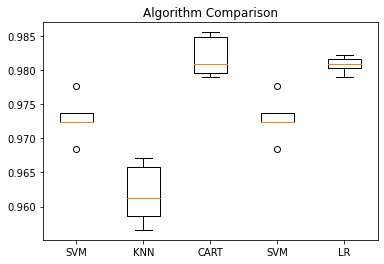

In [21]:
# Plot Compare Algorithms
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

In [22]:
# Make Predictions on Validation Dataset
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_val)

In [23]:
# Evaluate predictions
print('Accuracy score:', accuracy_score(y_val, predictions))
print(confusion_matrix(y_val, predictions))
print(classification_report(y_val, predictions))

Accuracy score: 0.9815886375591794
[[   2    0    6]
 [   0 1649    3]
 [   5   21  215]]
              precision    recall  f1-score   support

        high       0.29      0.25      0.27         8
         low       0.99      1.00      0.99      1652
         mid       0.96      0.89      0.92       241

    accuracy                           0.98      1901
   macro avg       0.74      0.71      0.73      1901
weighted avg       0.98      0.98      0.98      1901



### Improving the data

#### 1. Oversampling

In [24]:
# Defining Oversampling Strategy
oversample = RandomOverSampler(sampling_strategy='minority')

In [25]:
# Fit and Apply the Transformation
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [26]:
X_over

,PEP01,PEP02,PEP03_avto,PEP03_home,PEP03_land,PEP04_adress,PEP04_region,PEP05,PEP09,PEP10,...,PEP19,PEP20,PEP21,PEP22,PEP23,PEP24,PEP25,PEP26,PEP27,PEP07
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14167,0,1,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,0,0,0
14168,0,0,0,0,1,0,0,1,0,0,...,0,1,1,0,0,1,0,0,0,0
14169,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,1,0,0,1,0
14170,1,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,1,1,0,1,0


In [27]:
X_train

,PEP01,PEP02,PEP03_avto,PEP03_home,PEP03_land,PEP04_adress,PEP04_region,PEP05,PEP09,PEP10,...,PEP19,PEP20,PEP21,PEP22,PEP23,PEP24,PEP25,PEP26,PEP27,PEP07
8379,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1873,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1289,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
394,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8010,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6734,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4512,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9234,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5600,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
results_over = []

for name, model in models:
    cv_results_over = cross_val_score(model, X_over, y_over, cv=kfold, scoring='accuracy')
    results_over.append(cv_results_over)
    print('%s: %f (%f)' % (name, cv_results_over.mean(), cv_results_over.std()))

SVM: 0.984688 (0.001422)
KNN: 0.979466 (0.001765)
CART: 0.991462 (0.001470)
SVM: 0.984688 (0.001422)
LR: 0.968953 (0.003212)


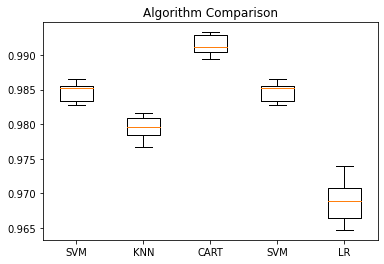

In [29]:
# Plot Compare Algorithms
pyplot.boxplot(results_over, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

In [30]:
# Make Predictions on Validation Dataset
model = DecisionTreeClassifier()
model.fit(X_over, y_over)
predictions = model.predict(X_val)

In [31]:
# Evaluate predictions
print('Accuracy score:', accuracy_score(y_val, predictions))
print(confusion_matrix(y_val, predictions))
print(classification_report(y_val, predictions))

Accuracy score: 0.9826407154129405
[[   2    0    6]
 [   0 1648    4]
 [   2   21  218]]
              precision    recall  f1-score   support

        high       0.50      0.25      0.33         8
         low       0.99      1.00      0.99      1652
         mid       0.96      0.90      0.93       241

    accuracy                           0.98      1901
   macro avg       0.81      0.72      0.75      1901
weighted avg       0.98      0.98      0.98      1901



#### 2. Combining Oversampling and Undersampling

In [39]:
# define Resampling
over = RandomOverSampler(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='majority')

# Define Pipeline
pipeline = Pipeline(steps=[('o', over), ('u', under), ('m', model)])

In [41]:
# Make Predictions on Validation Dataset
pipeline.fit(X_train, y_train)
predictions = model.predict(X_val)

In [42]:
# Evaluate predictions
print('Accuracy score:', accuracy_score(y_val, predictions))
print(confusion_matrix(y_val, predictions))
print(classification_report(y_val, predictions))

Accuracy score: 0.9831667543398211
[[   3    0    5]
 [   0 1649    3]
 [   3   21  217]]
              precision    recall  f1-score   support

        high       0.50      0.38      0.43         8
         low       0.99      1.00      0.99      1652
         mid       0.96      0.90      0.93       241

    accuracy                           0.98      1901
   macro avg       0.82      0.76      0.78      1901
weighted avg       0.98      0.98      0.98      1901

